# **Setup**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


1. Dependencies Installieren

In [ ]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib albumentations


labelme wird vorher schon herunterladen

2. Package importieren

In [1]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [2]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [4]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [5]:
#Model Speicherung
from tensorflow.keras.models import load_model

# Limit GPU Memory Growth

In [91]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [92]:
tf.config.list_physical_devices('GPU')

[]

# Getting the right PATH

In [7]:
current_path = Path().resolve()
print(current_path)

C:\Users\ttt\Documents\GitHub\BilderkennungAI


In [10]:
%pwd

'c:\\Users\\ttt\\Documents\\GitHub\\BilderkennungAI'

# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Shuffling


In [11]:
import random

In [12]:
l = os.listdir(current_path)
random.shuffle(l)
print(l)

['Wrong  Testing versions', 'logs', 'images_markup', 'data', 'MainProject.ipynb', 'README.md', '.gitignore', '.git']


Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



Image in eine tf data pipeline laden (Beispiel)

In [13]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [14]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image72.jpg'

In [15]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,[120,120], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = img/255
    return img

In [16]:
images = images.map(load_image)

In [17]:
images.as_numpy_iterator().next()

array([[[0.62352943, 0.5686275 , 0.53333336],
        [0.61960787, 0.5647059 , 0.5294118 ],
        [0.61960787, 0.5647059 , 0.5294118 ],
        ...,
        [0.62352943, 0.56078434, 0.50980395],
        [0.61960787, 0.5568628 , 0.5058824 ],
        [0.627451  , 0.5647059 , 0.5137255 ]],

       [[0.61960787, 0.5647059 , 0.5294118 ],
        [0.61960787, 0.5647059 , 0.5294118 ],
        [0.627451  , 0.57254905, 0.5372549 ],
        ...,
        [0.6392157 , 0.5764706 , 0.5254902 ],
        [0.627451  , 0.5647059 , 0.5137255 ],
        [0.627451  , 0.5647059 , 0.5137255 ]],

       [[0.61960787, 0.5647059 , 0.5294118 ],
        [0.6431373 , 0.5882353 , 0.5529412 ],
        [0.627451  , 0.57254905, 0.5372549 ],
        ...,
        [0.63529414, 0.57254905, 0.52156866],
        [0.64705884, 0.58431375, 0.53333336],
        [0.6392157 , 0.5764706 , 0.5254902 ]],

       ...,

       [[0.18039216, 0.16078432, 0.18431373],
        [0.15294118, 0.13333334, 0.15686275],
        [0.12156863, 0

In [18]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [19]:
images_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = images_generator.next()

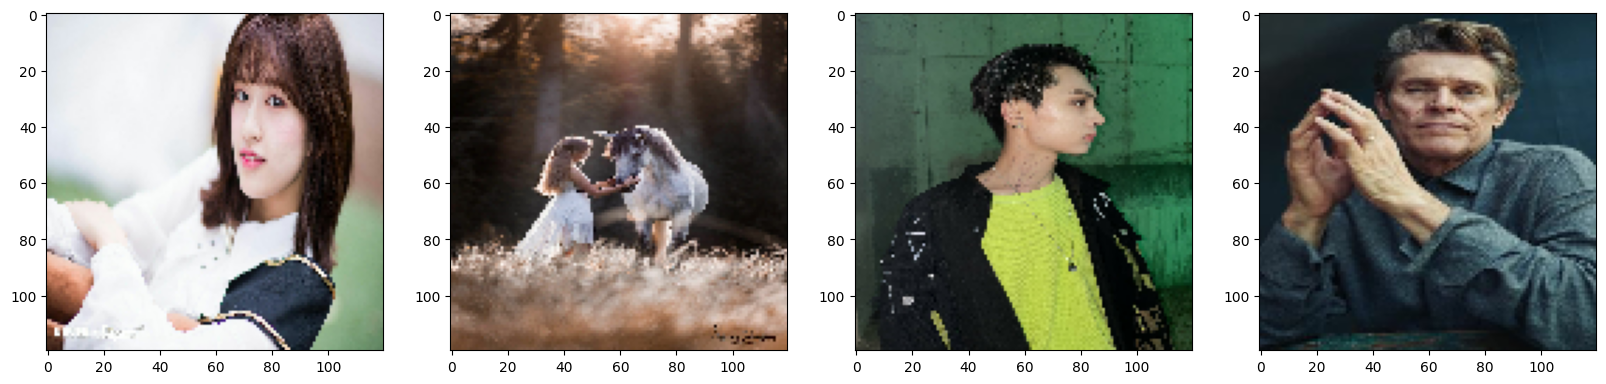

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [22]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))
#alb.RandomCrop(width=200,height=200)

Laden eines Beispielbilds

In [23]:
image_path = "image24"

In [24]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [25]:
size= img.shape
print(size)

(1200, 914, 3)


In [26]:
with open(os.path.join('data','train','labels',image_path+'.json'),'r') as f:
  label = json.load(f)

In [27]:
label['shapes'][0]['points']

[[139.54430379746827, 54.43037974683544],
 [764.8607594936709, 751.8987341772151]]

Koordinaten Extrahieren und Maßstab ändern

In [28]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [29]:
coords

[139.54430379746827, 54.43037974683544, 764.8607594936709, 751.8987341772151]

In [30]:
coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

In [31]:
coords

[0.15267429299504187,
 0.04535864978902954,
 0.8368279644350886,
 0.6265822784810127]

Augmentation implimentieren

In [40]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [41]:
augmented['bboxes'][0]


(0.15267429299504187,
 0.37341772151898733,
 0.8368279644350886,
 0.9546413502109705)

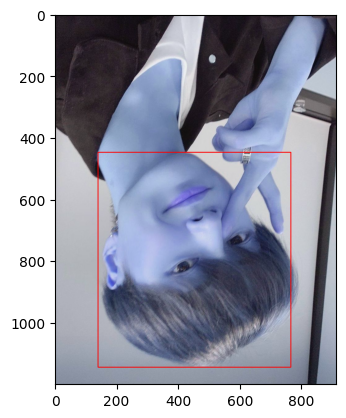

In [42]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [43]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [44]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8317323943661973, 0.5497395475629471, 0.5485, 0.0, 'face'].
y_max is less than or equal to y_min for bbox [0.44457068657685445, 0.2988298829882988, 0.6090461505166911, 0.16633663366336635, 'face'].
x_max is less than or equal to x_min for bbox [0.6501111218475215, 0.43881856540084385, 0.24749573227687047, 0.12130801687763712, 'face'].
x_max is less than or equal to x_min for bbox [0.7181190902121134, 0.4221409121851599, 0.3475594173268591, 0.0966643975493533, 'face'].
x_max is less than or equal to x_min for bbox [0.793085246766957, 0.005278437582475587, 0.11638954869358668, 0.8023225125362893, 'face'].
x_max is less than or equal to x_min for bbox [0.587722306910569, 0.6845641373080398, 0.2777629573170732, 0.030770099367660345, 'face'].
x_max is less than or equal to x_min for bbox [0.6308577692518498, 0.07355249204665959, 0.35583134322514964, 0.4128950159066808, 'face'].
x_max is less than or equal to x_min for bbox [0.6925925925925925

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [45]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [46]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [47]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [ ]:
train_images.as_numpy_iterator().next()

Labels vorbereiten

In [49]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [50]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [51]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [52]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [53]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2732 , 0.05597, 0.779  , 0.5986 ], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [54]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(1980, 1980, 300, 300, 540, 540)

7.2 Create Final Dataset (Image/Label)

In [55]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [56]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [57]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

7.3 View Images and Annotations

In [59]:
data_samples = train.as_numpy_iterator()

In [66]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


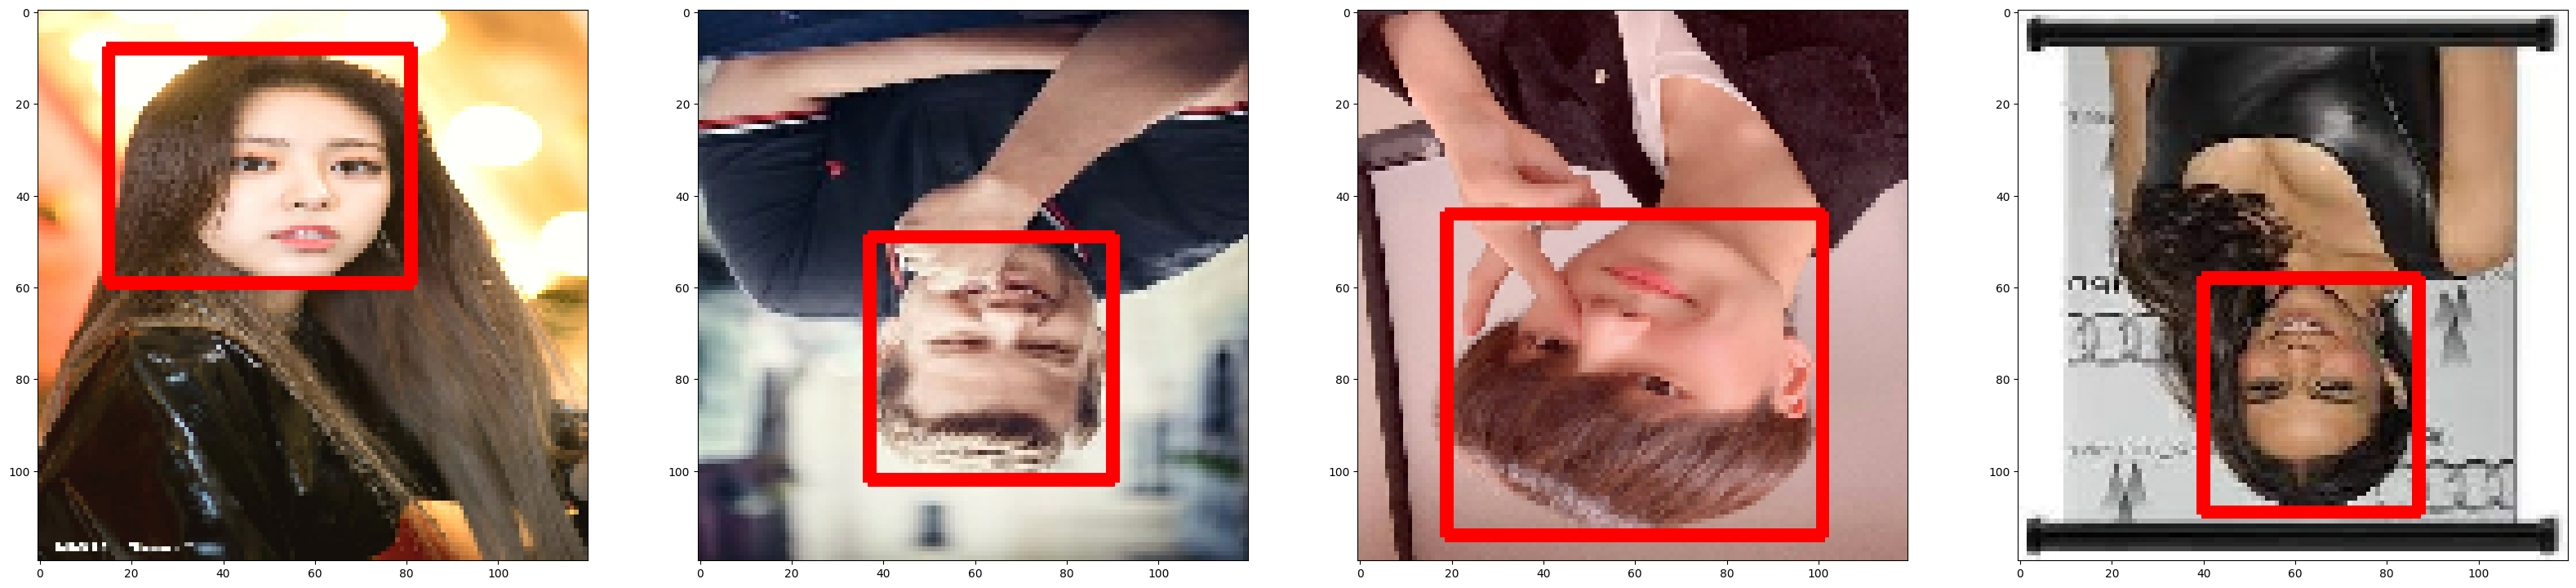

In [67]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [68]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [69]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [70]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [71]:
facetracker = build_model()

In [72]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [73]:
X, y = train.as_numpy_iterator().next()

In [74]:
X.shape

(8, 120, 120, 3)

In [75]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [76]:
classes, coords

(array([[0.5947095 ],
        [0.53333324],
        [0.41442806],
        [0.5453912 ],
        [0.49274606],
        [0.42638138],
        [0.5909213 ],
        [0.54746324]], dtype=float32),
 array([[0.31105444, 0.70902693, 0.34233946, 0.58464956],
        [0.28993633, 0.56063354, 0.3758172 , 0.51460004],
        [0.3256918 , 0.7146835 , 0.36209503, 0.5939514 ],
        [0.18842706, 0.5574569 , 0.30896714, 0.62060857],
        [0.32257116, 0.6715378 , 0.2858581 , 0.51485556],
        [0.28770685, 0.63764155, 0.36583176, 0.61560285],
        [0.23959509, 0.6467593 , 0.41080984, 0.5953438 ],
        [0.28180522, 0.5717715 , 0.33527195, 0.5664849 ]], dtype=float32))

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [77]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [78]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [79]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [80]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [81]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.377721>

In [82]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.665514>

In [83]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.377721>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [84]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [85]:
model = FaceTracker(facetracker)

In [86]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [88]:
logdir='logs'

In [89]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [93]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
  4/248 [..............................] - ETA: 23:22 - total_loss: 0.5546 - class_loss: 0.0179 - regress_loss: 0.5456

KeyboardInterrupt: 

## 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()